# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt 

In [12]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

<AxesSubplot:>

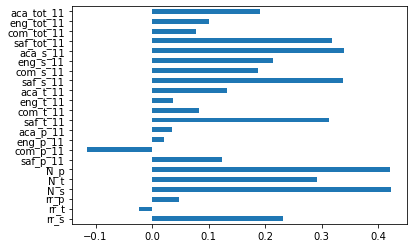

In [13]:
correlation_sat = combined.corr()
correlation_sat = correlation_sat["sat_score"]
correlation_sat.loc[survey_fields].plot.barh()

From the correlation between the data, it can be found that, the saf_t_11 and saf_s_11 which measure how teachers and students perceive safety at school correlated highly with sat_score

## Safety Correlation Plot

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

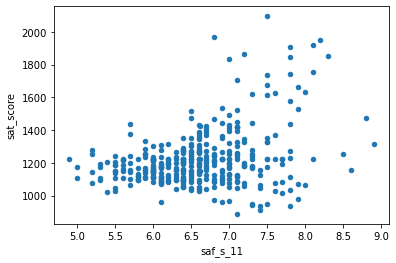

In [14]:
combined.plot.scatter("saf_s_11", "sat_score")

It can be found that safety perceive by students sure have positive relationship with SAT_scores 

<AxesSubplot:xlabel='saf_t_11', ylabel='sat_score'>

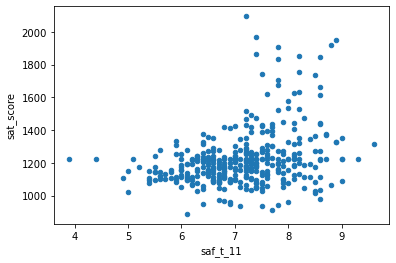

In [15]:
combined.plot.scatter("saf_t_11", "sat_score")

From the teacher perspective of safety, it also have positive relationship with SAT_scores

In [16]:
#Now we are going to find out about the safety for each borough 
pd.options.display.max_seq_items = 4000
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       'Demographic', 'School Name', 'Cohort', 'Total Cohort',
       'Total Grads - n', 'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n', 'Local - % of cohort',
       'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED',
       'NUMBER OF SECTIONS', 'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS',
  

In [45]:
combined_average = combined.groupby("school_dist")[["saf_t_11","saf_p_11","saf_s_11"]].mean().mean(axis = 1)
combined_average.sort_values(ascending = False )

school_dist
22    7.833333
24    7.746154
04    7.714286
12    7.677778
06    7.656667
20    7.620000
30    7.585185
25    7.525000
02    7.522998
28    7.466667
14    7.438095
07    7.397436
32    7.388889
09    7.366667
01    7.356204
13    7.276923
10    7.274242
03    7.236111
08    7.215505
31    7.180000
26    7.160000
18    7.118182
21    7.093939
11    7.088889
05    7.085714
23    7.055556
27    7.050000
29    6.962500
15    6.940741
17    6.933333
19    6.752778
16    6.333333
dtype: float64

Some have low district safety such as district number 16 and 19

## Race per SAT_SCORE 

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

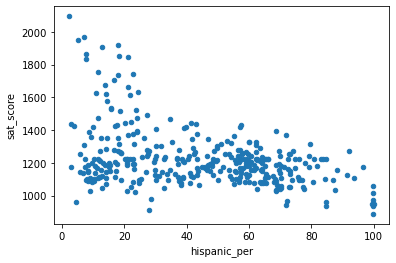

In [47]:
#Hispnaics percentage to sat_score 
combined.plot.scatter("hispanic_per", "sat_score")

It can be found based on the scatterplot that the hispanic_percentage as it is higher, it has lowes SAT_scores

In [49]:
#further researh in hispanic percent higher than 95% 
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From the school data, majorities are language schools with low numbers of students for each

In [51]:
#further research in hispanic percent lower than 10% 
combined[combined["hispanic_per"] < 10][combined["sat_score"] >1800]["SCHOOL NAME"]

<ipython-input-51-cae9ed2dc34b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined[combined["hispanic_per"] < 10][combined["sat_score"] >1800]["SCHOOL NAME"]


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Highly known schools, with high ranking, and have a lot of students with its offering for specialized studies 

## Gender per SAT_Score 

In [52]:
correlation = combined.corr()["sat_score"]

<AxesSubplot:>

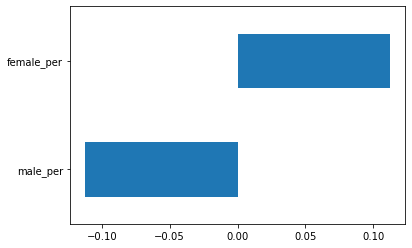

In [63]:
correlation.loc[["male_per", "female_per"]].plot.barh()

It can be found that the number of female students, possitively correlated with SAT_scores compare with negative corrleation between male_per to SAT_scores 

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

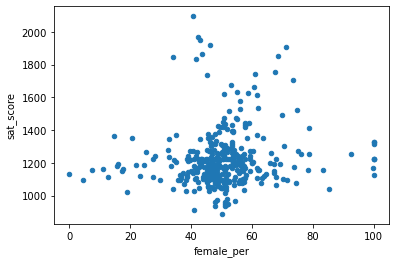

In [66]:
combined.plot.scatter("female_per", "sat_score")

From the scatterplot, it has weak positive correlation, but still there are some schools with 100% female with lower score sat compare with est 40% percentage of female school higher than 2000 scores 

In [67]:
#further research for school with female_per greather than 60% and sat score greater than 1700 
combined[combined["female_per"] > 60][combined["sat_score"] >1700]["SCHOOL NAME"]

<ipython-input-67-32ababb87183>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined[combined["female_per"] > 60][combined["sat_score"] >1700]["SCHOOL NAME"]


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

This is usually college preparation school 

## AP_per to SAT scores 

In [71]:
combined["ap_per"] = combined["AP Test Takers "]/ combined["total_enrollment"]

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

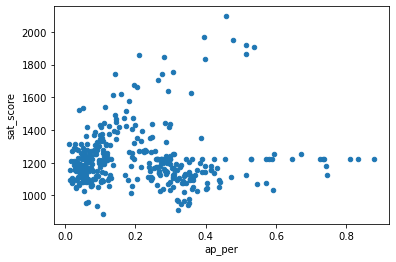

In [73]:
combined.plot.scatter("ap_per", "sat_score")

from the data, it can be found that there is very weak positive correlation between the ap_percentage and SAT Scores 

## Class Size to SAT_scores 

<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

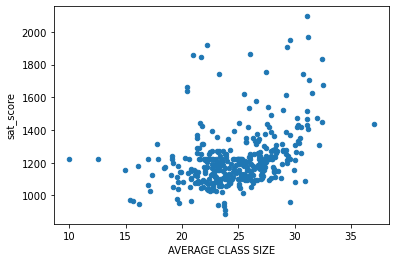

In [79]:
#Plotting the CLass Size correlation
combined.plot.scatter("AVERAGE CLASS SIZE", "sat_score")

For the class size, it actually have weak positive relationship with the SAT Scores 